# Project 4: Machine Learning to Excise RFI

In this porject we simulte the response to two sources in a time frequency spectograph and then use Machine Learning to attempt to remove the RFI from the generated samples.

## Contents

1. Array Configuration (and the EVLA's Characteristics)
1. Calculation of Dynamic Spectra
1. RFI Contamination
1. Creating Data Set
1. Machine Learning Training / Evaluation
1. Excising the RFI
1. Conclusion

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import cmath

from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

from sklearn.metrics import coverage_error, label_ranking_average_precision_score, label_ranking_loss
from sklearn.metrics import confusion_matrix
from sklearn.metrics import multilabel_confusion_matrix
from sklearn.metrics import accuracy_score

from scipy.stats import moment
from scipy.stats import norm

## 1. Array configuration (and the EVLA's Characteristics)

Here we import the data of for the EVLA taken from 

Read in the data from a modified version of the document found on: https://science.nrao.edu/facilities/vla/docs/manuals/oss2016A/ant_positions.pdf

In [2]:
#Reading in all data from raw data file.
RawData = []
f = open('Raw_ant_positions.txt', )
for line in f: #Create Array of all data.
    LineArray = line.split()
    RawData.append(LineArray)

Manipulate the data into North, East and West datasets (for the D configuration).

In [3]:
#Split dataset By orientation (West, East and North)
WAntennae = RawData[1:25]
EAntennae = RawData[25:49]
NAntennae = RawData[49:]

#Split location data into Numpy Arrays of various configurations of the satalites
ArrayConfiguration = 'D'
W = np.array([])
for i in WAntennae:
    if ArrayConfiguration in i:
        W = np.append(W,i[-4:])
W = np.reshape(W,(len(W)//4,4)).astype('float64') #Shape each matrix, so that each row of data is for one receiver with data columns of Lx(ns), Ly(ns), Lz(ns) and R(m).

E = np.array([])
for i in EAntennae:
    if ArrayConfiguration in i:
        E = np.append(E,i[-4:])
E = np.reshape(E,(len(E)//4,4)).astype('float64')

N = np.array([])
for i in NAntennae:
    if ArrayConfiguration in i:
        N = np.append(N,i[-4:])
N = np.reshape(N,(len(N)//4,4)).astype('float64')

Plot the retrieved antennae positions for the given configuration (in the this iteration we use the D configuration).

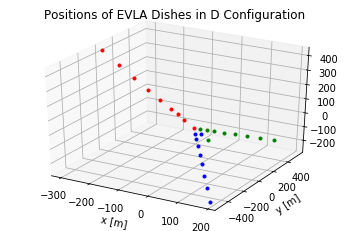

In [4]:
c = 299792458 #[m/s]

#Format plot:
fig = plt.figure()
fig.add_subplot(111,projection='3d')
plt.grid()
plt.xlabel('x [m]'); plt.ylabel('y [m]')#; plt.zlabel('z [m]')
plt.title(f'Positions of EVLA Dishes in {ArrayConfiguration} Configuration')

#Calculate distances given by light travel time between satalites n_x,n_y,n_z from original table:
NDist = N[:,:3]*10**(-9)*c #[m]
EDist = E[:,:3]*10**(-9)*c #[m]
WDist = W[:,:3]*10**(-9)*c #[m]
plt.plot(NDist[:,0],NDist[:,1],NDist[:,2],'r.')
plt.plot(WDist[:,0],WDist[:,1],WDist[:,2],'b.')
plt.plot(EDist[:,0],EDist[:,1],EDist[:,2],'g.')
plt.draw()

We store all of the antennae in a single object for easier manipulation. (27 antennae with 3 spatial coordinates each).

In [5]:
N_m = NDist[:,:3]
E_m = EDist[:,:3]
W_m = WDist[:,:3]
antennae = np.concatenate((N_m,E_m))
antennae = np.concatenate((antennae,W_m))
print(f'The x,y,z coordinates for all antennaes are of the shape: {antennae.shape}')

The x,y,z coordinates for all antennaes are of the shape: (27, 3)


## 2. Calculation of Dynamic Spectra

## Contents

1. Array Configuration (and the EVLA's Characteristics)
1. Calculation of Dynamic Spectra
1. RFI Contamination
1. Creating Data Set
1. Machine Learning Training / Evaluation
1. Excising the RFI
1. Conclusion

We consider a field of view with two point sources. These are defined as follows:

|Point Source|Position|Flux Density|
|:------:|:------------------:|:----:|
|Source 1|J 05 00 00 +45 00 00|3.6 Jy|
|Source 2|J 05 00 10 +45 03 00|5.8 Jy|

We calculate the response of a given baseline pair $ij$ on the field of view containing only our two point sources. The response as a function of frequency ($f$) and time ($t$) can be calculated as:
$$ R_{ij}(f,t) = \sum_{K=1}^{2}I_k \cdot exp(-2i\pi \cdot (u_{ij}(f,t) \cdot x_k + v_{ij}(f,t) \cdot y_k)) $$

Where $x$ is the hour angle and $y$ is the declination of the two sources in radians and $I_k$ is the flux density of either source in janskys (Jy). Furthermore, our defined $u_{ij}(f,t)$ and $v_{ij}(f,t)$ variables are the uv space coordinates that our $ij$-baseline samples. They are defined as:

$$\vec{p}_{ij}(f,t) = f\frac{1}{c} \cdot \vec{T(H,\delta)}\cdot (\vec{r_i} - \vec{r_j})$$

Where $\vec{p}_i(f,t)$ is the positional vector of antenna $i$ (in the uvw coordinate system) and $r_k$ is the cartesian position of antenna $k$ as defined in chapter 4 of "Interferometry and Synthesis" by A. Richard Thompson, James M. Moran George and W. Swenson Jr. (the above equation is equivalent to eqn. 4.1 of third edition: https://link.springer.com/content/pdf/10.1007%2F978-3-319-44431-4.pdf#page=153). $T(H,\delta)$ is the 3-dimensional rotation from the xyz to the uvw coordinate system as seen in eqn 4.1 (please see the `basechange` variable in `single_baseline` function).

To generate a response to our field of view i.e. $R_{ij}(f,t)$ we first we define a function with four primary variables:
```python
def single_baseline(antenna1, antenna2, frequency, HA):
``` 
which returns $u_{ij}$ and $v_{ij}$ as defined above for two antennae of your choice, a frequency (Hz), and an hour angle as defined by its in the inputs. Here antenna1 and antenna2 are the xyz coordinate system focussed three dimensional coordinates of antenna i and j respectively.


In [6]:
def single_baseline(antenna1, antenna2,
                    frequency=1.5,
                    HA=0,
                    uv=True,
                    d_deg=45):
    c = 299792458 #units: [m/s]
    frequency = frequency*10**9
    baseline = antenna1-antenna2
    
    if uv:
        H_rad = 2*np.pi * HA/24 #units: [rad]
        d = 2*np.pi * d_deg/360 #units: [rad]
        basechange = np.array([[np.sin(H_rad) , np.cos(H_rad) , 0], # No longer used as it failed to compute correctly with arrays of frequency and HA,
                               [-np.sin(d)*np.cos(H_rad) , +np.sin(d)*np.sin(H_rad) , np.cos(d)], # instead we multiply out the u and v values ourselves below.
                               [+np.cos(d)*np.cos(H_rad) , -np.cos(d)*np.sin(H_rad) , np.sin(d)]]) 
        baseline_u = (np.sin(H_rad)*baseline[0] + np.cos(H_rad)*baseline[1])*frequency/c
        baseline_v = (-np.sin(d)*np.cos(H_rad)*baseline[0] + np.sin(d)*np.sin(H_rad)*baseline[1] + np.cos(d)*baseline[2])*frequency/c
    else:
        baseline_u , baseline_v = baseline[0] , baseline[1]
    
    return baseline_u, baseline_v #units: [lambda]

To display a classic perspective of the baselines we plot them in the uv space before defining a response function for a given baseline. There will be 702 baselines, but we will only consider 351 as we do not need to consider the conjugate of a given baseline as its response is identical in the absolute value. Here we plot all 702.

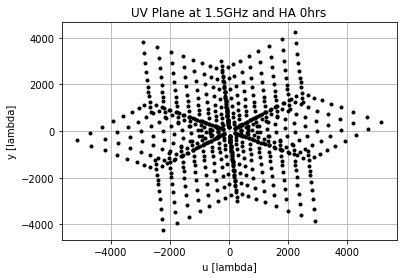

In [7]:
uv_baselines = np.array([[0,0]])
for i in range(antennae.shape[0]):
    for j in range(antennae.shape[0]):
        if i!=j:
            utemp, vtemp = single_baseline(antennae[i],antennae[j])
            temp = np.asarray([[utemp,vtemp]])
            uv_baselines = np.concatenate((uv_baselines,temp),axis=0)
plt.title('UV Plane at 1.5GHz and HA 0hrs')
plt.grid()
plt.xlabel('u [lambda]')
plt.ylabel('y [lambda]')
plt.plot(uv_baselines[1:,0],uv_baselines[1:,1],'k.')
plt.show()

The largest angular scale that the EVLA in D configuration can resolve is 970 arcsec. Our two sources are 234 arcsec appart and are thus resolved. We do however have to take into accound that the lobes of our array will not detect the full flux of the source. (Resolution values: https://science.nrao.edu/facilities/vla/docs/manuals/oss/performance/resolution)

We assume that the lobe of our array has a normal distribution and we make considerations around what the second sources flux might be.



In [8]:
source2_flux = 5.8E-3 #[Jy]
source2_dist = ((360*60*60 * 10/(24*60*60))**2 + (3*60)**2)**0.5 #[arcsec]

sigma1 = (1.15*1.0E9/3.0E8/25)*180/np.pi *60**2 #[arcsec]
f1 = norm.pdf(source2_dist,loc = 0,scale=sigma1)
scale1 = f1/norm.pdf(0,loc = 0,scale=sigma1) #Scalar

sigma2 = (1.15*2.0E9/3.0E8/25)*180/np.pi *60**2 #[arcsec]
f2 = norm.pdf(source2_dist,loc = 0,scale=sigma2)
scale2 = f2/norm.pdf(0,loc = 0,scale=sigma2) #Scalar

print(f'The distance from the centre of the field of view to the second source is {int(source2_dist)} arcsec')
print(f'The calculated std deviation is approximately {int(sigma1/60)} arcmin')
print(f'The minimum and maximum flux of source 2 are {5.8*scale1} mJy and {5.8*scale2} mJy respectively (at 1 and 2 GHz).')

The distance from the centre of the field of view to the second source is 234 arcsec
The calculated std deviation is approximately 527 arcmin
The minimum and maximum flux of source 2 are 5.799840837422671 mJy and 5.799960208946188 mJy respectively (at 1 and 2 GHz).


As printed above the difference in incoming flux depending on the beamwidth is negligable for our calculations. We therefore continue with the unaltered $5.8$ mJy as our flux density for source 2.

The below function is our main call for our field of view without any errors or RFI. It returns an array of $R_{ij}(f,t)$ which is ready to plot.

In [9]:
def clean_response(antenna1No, antenna2No,
                   freq_samples=64,
                   freq_min=1., #units: [Ghz],
                   freq_max=2., #units: [Ghz]
                   H_samples=60*3*2,
                   H_min=-1.5, #[hrs]
                   H_max=1.5, #[hrs]
                  ):
    antenna1 = antennae[antenna1No-1]
    antenna2 = antennae[antenna2No-1]
    
    source1 = np.asarray([0.,0.])
    source2 = np.asarray([2*np.pi * 10/(24*60*60),2*np.pi*3/(360*60)])
    meshgrid = np.mgrid[freq_min : freq_max : freq_samples*1j,
                        H_min : H_max : H_samples*1j]
    freq = meshgrid[0]
    H = meshgrid[1]
    
    # Plot our frequency and HA meshgrids for clarity
    """plt.subplot(211)
    plt.title('freq')
    plt.imshow(freq,origin='lower')
    plt.subplot(212)
    plt.title('HA')
    plt.imshow(H,origin='lower')"""
    
    baseline_u, baseline_v = single_baseline(antenna1,antenna2,freq,H) #units: [lambda]
    #baseline_u , baseline_v = baseline_u[0][0] , baseline_v[0][0]
    response = (3.6*np.exp(-2.0j*np.pi*(baseline_u*source1[0] + baseline_v*source1[1]))
                +5.8*np.exp(-2.0j*np.pi*(baseline_u*source2[0] + baseline_v*source2[1])))
    print(response.shape)
    return response

We select the antennae numbers of which we would like to see the response function and call the response function. The antenna are listed in order of their appearance in our read in positional data (see table below).

|Orientation|Number|Equivalent Station Names|
|:---------:|:----:|:-----:|
|North| VA01 : VA09 | N1 : N9 |
|East | VA11 : VA18 | E1 : E9 |
|West | VA19 : VA27 | W1 : W9 |

For "Equivalent Station Names" please see: https://science.nrao.edu/facilities/vla/docs/manuals/oss2016A/ant_positions.pdf

In [10]:
# Selecting the Antennae whos baseline we would like to see the response function of.
#  1- 9: North
# 11-18: East
# 19-27: West
antenna1No = 27
antenna2No = 1

# Pulling correct x,y,z coordinates for the given antenna Numbers
#antenna1 = antennae[antennaNo1-1]
#antenna2 = antennae[antennaNo2-1]

# Calculating the response function for the baseline defined by the two selected antennae.
response = clean_response(antenna1No, antenna2No)#,freq_samples=64,H_samples=360)

(64, 360)


We take a quick look at a single baseline response ie. in this case: $R_{27,01}(f,t)$ before moving on to generating RFI.

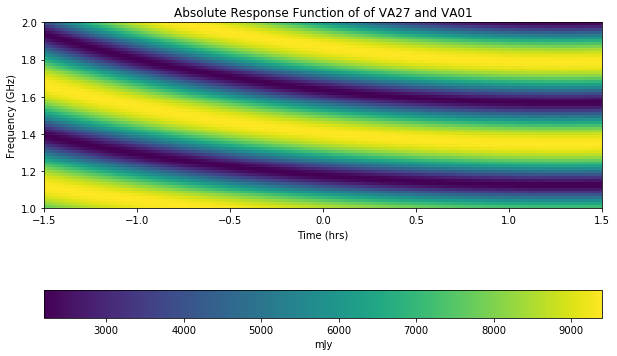

In [11]:
plt.figure(figsize=(10,10))
ant1 , ant2 = str(antenna1No), str(antenna2No)
if antenna1No <10:
    ant1 = '0'+str(antenna1No)
if antenna2No <10:
    ant2 = '0'+str(antenna2No)
plt.title(f'Absolute Response Function of of VA{ant1} and VA{ant2}') #Make antenna selection automatic. 
plt.xlabel('Time (hrs)')
plt.ylabel('Frequency (GHz)')
plt.imshow(np.abs(response)*1000,origin='lower',extent=[-1.5,1.5,1.0,2.0])
plt.colorbar(orientation='horizontal',label='mJy')
plt.show()

We add the noise now before moving on. "The NARO VLA Sky Survey" (J. J. Condon et al. https://iopscience.iop.org/article/10.1086/300337/meta and Neal Jackson's Interferometry Class) lists the conditions for their sky survey (which was completed in a compact configuration similar to ours). The noise follows a normal distribution with equation 9 of "The NARO VLA Sky Survey" defining the standard deviation and the respective values as:

$$ \sigma_n = \frac{\sqrt{2}k_bT_s}{\eta_a\eta_cA\sqrt{N_b\tau\Delta\nu}} $$

|Variable | Value | Definition|
|---|---|----|
|$k_b$| $1.380649×10^{−23} JK^{-1}$ | Boltzman constant|
|$T_s$| $\approx 33$K | System temperature |
|$\eta_a$| $0.51$ | Aperture efficiency|
|$\eta_c$| $0.79$ | Continuum correlator|
|$A$ | $25^2\pi$ | Area of one 25m Telescope|
|$N_b$ | 1 | Number of baselines|
|$\tau$| Pixel width | Time integrated over |
|$\Delta\nu$ Pixel height | Bandwidth|

We generate a noise overlay for our spectrographs and plot it below.

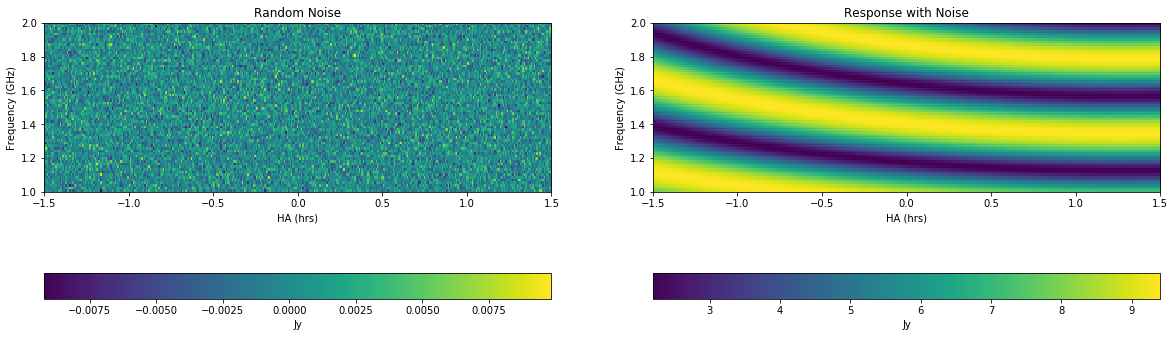

In [12]:
def noise_func(freq_samples=64,
          freq_min=1., #units: [Ghz],
          freq_max=2., #units: [Ghz]
          H_samples=60*3*2,
          H_min=-1.5, #[hrs]
          H_max=1.5, #[hrs]
         ):
    # Define varibales
    k_b = 1.380649E-23
    T_s = 33
    eta_a = 0.51
    eta_c = 0.79
    A = 25**2*np.pi
    N_b = 1.
    tau = (H_max-H_min)*24*60*60/H_samples #s
    dnu = (freq_max-freq_min)/freq_samples*10.0E9 #Hz
    
    # Calculate sigma of the noise and generate a noise array
    sigma = (2**0.5*k_b*T_s)/(eta_a*eta_c*A*np.sqrt(N_b*tau*dnu))
    noise_array = np.random.normal(loc=0,scale=sigma,size=(H_samples,freq_samples))
    
    return noise_array.T

# Call function and define new noisy response array
noise = noise_func()*10.0E26 #[Jy]
noisy_response = response+noise

# Plot both noise and the noisy response.
plt.figure(figsize=(20,10))
plt.subplot(121)
plt.title('Random Noise')
plt.xlabel('HA (hrs)')
plt.ylabel('Frequency (GHz)')
plt.imshow(noise,origin='lower',extent=[-1.5,1.5,1,2])
plt.colorbar(orientation='horizontal',label='Jy')
plt.subplot(122)
plt.title('Response with Noise')
plt.xlabel('HA (hrs)')
plt.ylabel('Frequency (GHz)')
plt.imshow(abs(noisy_response),origin='lower',extent=[-1.5,1.5,1,2])
plt.colorbar(orientation='horizontal',label='Jy')
plt.show()

## 3. RFI Contamination

## Contents

1. Array Configuration (and the EVLA's Characteristics)
1. Calculation of Dynamic Spectra
1. RFI Contamination
1. Creating Data Set
1. Machine Learning Training / Evaluation
1. Excising the RFI
1. Conclusion

As the EVLA is in D configuration for this simulation we assume that all RFI sources in the given range arrive at each baseline as the antenna themselves are too close to one another to allow for signals to not be coherent upon arrival.

No external interference should be generated between the frequencies of 1400–1427 MHz, 1660.6–1670.0 MHz as these are protected for radio astronomy(https://science.nrao.edu/facilities/vla/docs/manuals/obsguide/rfi). To define our sources of RFI we use the official VLA website. For the L-Band their list of RFI sources can be found under: https://science.nrao.edu/facilities/vla/observing/RFI/L-Band

We import this data from a modified csv file.
The modifications include:
1. Spelling corrections to classifications (ie. intermittant corrected to intermittent).
1. Classifying satalites (unlabeled sources) as 'NA'
1. Classifying 'FAA ASR radar' at 1330 MHz as continuous along with the other ASR radar counterparts.
1. Adding the amplitude of each continuous source by reading off of the plots from: https://science.nrao.edu/facilities/vla/observing/RFI/jul-2014-d-configuration/L-Band_spectra_201407D
1. Estimating the apmplitudes of each intermittent sources based on the average RFI intensity or the intensity of the most similar source (and $-0.5 log_{10}(Amplitude)$ Jy if otherwise unknown).
1. Added location specific seperations to the Titles of the sources. See explanation of "unique sources" below.

We import this data and make some simple modifications to extract the data we need.

In [13]:
df = pd.read_csv('NARO_RFI_L-Band.csv')
df['AmpJy'] = 10**(df['Ampdb']/10)

NARO_RFI = np.genfromtxt('NARO_RFI_L-Band.csv', delimiter=',',dtype=np.str)
RFI_peaks = NARO_RFI[1:,0]
RFI_labels = NARO_RFI[1:,1]
RFI_class = np.core.defchararray.lower(NARO_RFI[1:,3])
RFI_amp = np.asarray(df['AmpJy'])

df['Classification'] = RFI_class

# Define as a [N,2] array with the second axis determining the range of the RFI (point if second value is nan).
RFI_pos = np.zeros((RFI_peaks.size,2))
for i in range(RFI_peaks.size):
    if '-' in RFI_peaks[i]:
        RFI_pos[i] = np.float64(RFI_peaks[i].split('-'))
    else:
        RFI_pos[i,0] = np.float64(RFI_peaks[i])
        RFI_pos[i,1] = np.float64(RFI_peaks[i])
df['Frequency'] = RFI_pos[:,0]
df.insert(1,'Upper Frequency',RFI_pos[:,1],True)

We take a look at the header of our data to exemplify the modifications we have made.

In [14]:
df.head(5)

,Frequency,Upper Frequency,Title,Origin,Classification,Ampdb,AmpJy
0,1606.00,1606.00,GLONASS L1,OHD,continuous,0.6,1.148154
1,1616.00,1616.00,GLONASS L1,OHD,continuous,0.6,1.148154
2,1565.42,1565.42,GPS L1 jamming,NM/WSMR,continuous,0.2,1.047129
3,1585.42,1585.42,GPS L1 jamming,NM/WSMR,continuous,0.2,1.047129
4,1233.71,1233.71,FAA ARSR4 radar,NaN,continuous,0.0,1.000000


We extract the unique sources of RFI based off of their titles. Furthermore, we argue that all RFI sources which have both the same name and origin must be coming from the same unique source, meaning that if it is present all of its listed frequency ranges must be present. 

As an example we have modified the titles of the four "TARS Pulsed Radar" entries to be either "TARS Pulsed Radar NM" (origin: NM/Deming) or "TARS Pulsed Radar AZ" (origin: AZ/Ft Huachuca) as according to our previously stated assumption both "TARS Pulsed Radar NM" signal bands **must** only ever occur at the same time as one another.

We generate a list of all unique sources below.

In [15]:
unique_sources = df['Title'].unique()
unique_sources_global = unique_sources
for i in range(len(unique_sources)):
    print(f'Unique Source No. {i}: {unique_sources[i]}')

Unique Source No. 0: GLONASS L1
Unique Source No. 1: GPS L1 jamming
Unique Source No. 2: FAA ARSR4 radar
Unique Source No. 3: IRIDIUM satellites
Unique Source No. 4: FAA ASR radar
Unique Source No. 5: GPS/Galileo/GLONASS L5
Unique Source No. 6: GLONASS L2
Unique Source No. 7: GPS L1
Unique Source No. 8: GPS L2
Unique Source No. 9: VLA modem
Unique Source No. 10: PCS cell phone base stations
Unique Source No. 11: internal birdie
Unique Source No. 12: AEROSTAT
Unique Source No. 13: COMPASS E6
Unique Source No. 14: INMARSAT satellites
Unique Source No. 15: GOES weather satellite
Unique Source No. 16: NOAA weather satellite
Unique Source No. 17: TARS pulsed radar AZ
Unique Source No. 18: TARS pulsed radar NM
Unique Source No. 19: 2nd harmonic VLA radios
Unique Source No. 20: Aeronautical IFF/air2gnd
Unique Source No. 21: Aeronautical IFF/gnd2air
Unique Source No. 22: RATSCAT Low FQ
Unique Source No. 23: WSMR RAJPO transponder
Unique Source No. 24: High alt balloon
Unique Source No. 25: Tes

To generate the RFI we use the respective upper and lower bounds of frequency to determine what channel it appears in. All channels in which it appears displays its amplitude. We differentiate how we add each source of RFI based off of its "Classification" (see: https://science.nrao.edu/facilities/vla/observing/RFI/L-Band).

Since we do not know how their classifications have been defined, we define the differences ourselves. The function `add_RFI2(...)` below introduces these differences. Although our function is built to adress all 6 distinct classifications, in this simulation we argue the following:

1. **"Continuous"** sources are always present.
1. "NA" sources are satelites and are always in sight of the array as they refer to satelites groups each. We thusly justify treating their RFI signals as continuous sources.
1. **"Malfunction"** sources are assumed to act in a binary fashion (either on or off for the whole period). We assume that if the malfunction is present we would know about it and therfore demonstrate what we expect to happen if it is present. Meaning we simulate our RFI with the malfunction active.
1. **"Intermittent"** sources are generated by a random number of occurances variable `NoOccurances` which is an integer between 1 and 10. For each of these occurances the signal is added for the time range determined by two randomly generated times with a mean of `3*i/NoOccurances-1.5` and a standard deviation of `3/NoOccurances`. The amplitudes do not act additively in regions where the random generated time windows overlap. These values were selected to generate a seemingly random 'intermittent' signal.
1. **"Pulsed & Intermittent"** sources are both radars. Radars generally 'pulse' with a dead space (pulse rate for our purposes) of maximally in the seconds range (https://www.radartutorial.eu/01.basics/Pulse%20Repetition%20Frequency%20(PRF).en.html). As the data we are generating has a resolution of 30s (due to computing restraints) we argue that these sources follow the same random paterns as our "Intermittent" sources as we do not resolve their pulsated nature.
1. **"Sporadic"** sources are generated similarly to the intermittent sources but with `NoOccurances` lying between 1 and 100.

In [16]:
def RFI_generator2(RFI_pos, unique_classes, RFI_amp, idealized=False,
                     freq_samples=64,
                     H_samples=3*60*2,
                     freq_min=1,
                     freq_max=2,
                     H_min=-1.5,
                     H_max=1.5):
    meshgrid = np.mgrid[freq_min : freq_max : freq_samples*1j,
                        H_min : H_max : H_samples*1j]
    freq = meshgrid[0]
    H = meshgrid[1]
    
    freq_pixel = (freq_max-freq_min)/freq_samples
    time_pixel = (H_max-H_min)/H_samples
    
    RFI = np.zeros(freq.shape)
    pixel_labels = np.zeros((freq.shape[0],freq.shape[1],32))

    # Add RFI from each unique_class.
    try:
        NumberOfClasses = unique_classes.size
    except:
        NumberOfClasses = 1
    for i in range(NumberOfClasses):
        location = np.where(RFI_labels == unique_classes[i])
        try:
            label_temp = np.where(unique_sources_global == unique_classes[i])[0][0]
        except:
            if isinstance(unique_classes,str):
                label_temp = np.where(unique_sources_global == unique_classes)[0][0]
            else:
                print('Your list of input classes is neither a list or string of valid class(es)')
        if idealized:
            classification = ['continuous']
        else:
            classification = RFI_class[location][0]
        if 'continuous' in classification:
            RFI , pixel_labels = add_RFI2(RFI,label_temp,pixel_labels,freq,H,freq_pixel,time_pixel,'continuous')
        elif 'intermittent' in classification:
            if 'pulsed' in classification:
                RFI , pixel_labels = add_RFI2(RFI,label_temp,pixel_labels,freq,H,freq_pixel,time_pixel,'pulsed')
            else:
                RFI , pixel_labels = add_RFI2(RFI,label_temp,pixel_labels,freq,H,freq_pixel,time_pixel,'intermittent')
        elif 'malfunction' in classification:
            RFI , pixel_labels = add_RFI2(RFI,label_temp,pixel_labels,freq,H,freq_pixel,time_pixel,'malfunction')
        elif 'sporadic' in classification:
            RFI , pixel_labels = add_RFI2(RFI,label_temp,pixel_labels,freq,H,freq_pixel,time_pixel,'sporadic')
        elif 'na' in classification:
            RFI , pixel_labels = add_RFI2(RFI,label_temp,pixel_labels,freq,H,freq_pixel,time_pixel,'na')
    return RFI , pixel_labels

In [17]:
# We add RFI based on frequency range and class dependant. ie. Depending on the RFI classification we use different time sampling methods to emulate their classification.
def add_RFI2(RFI_temp, label_temp, pixel_labels, freq, H, freq_pixel, time_pixel, clabel):#, RFI_range, amplitude, freq_pixel, time_pixel, freq, H, clabel):
    # Calling specific values for given class no:
    location = np.where(RFI_labels == unique_sources_global[label_temp])

    # Looping over multiple entries found under same class name / label.
    if clabel == 'continuous':
        for q in range(RFI_amp[location].shape[0]):
            amplitude = RFI_amp[location][q]
            RFI_range = RFI_pos[location][q]*10**-3
            RFI_temp = np.where((RFI_range[0]-freq_pixel/2<=freq) & (RFI_range[1]+freq_pixel/2>=freq),
                                RFI_temp+amplitude, RFI_temp)
            pixel_labels[:,:,label_temp] = np.where((RFI_range[0]-freq_pixel/2<=freq) & 
                                                    (RFI_range[1]+freq_pixel/2>=freq),
                                                    1, pixel_labels[:,:,label_temp])
    elif (clabel == 'pulsed') or (clabel == 'intermittent'):
        temp = np.zeros((freq.shape[0],freq.shape[1],RFI_amp[location].shape[0]))
        NoOccurances = np.random.randint(1,10)
        for i in range(NoOccurances):
            rand = np.random.normal(loc=3*i/NoOccurances-1.5,scale=3/NoOccurances,size=(2))
            for q in range(RFI_amp[location].shape[0]):
                amplitude = RFI_amp[location][q]
                RFI_range = RFI_pos[location][q]*10**-3
                data_locations = np.where((RFI_range[0]-freq_pixel/2<=freq) & (RFI_range[1]+freq_pixel/2>=freq) &
                                          (H>=rand.min()-time_pixel/2) & (H<=rand.max()+time_pixel/2))
                temp[data_locations[0],data_locations[1],q] = amplitude
                if NoOccurances != 0:
                    pixel_labels[:,:,label_temp] = np.where((RFI_range[0]-freq_pixel/2<=freq) & (RFI_range[1]+freq_pixel/2>=freq) & 
                                                            (H>=rand.min()-time_pixel/2) & (H<=rand.max()+time_pixel/2),
                                                            1, pixel_labels[:,:,label_temp])
        RFI_temp += np.sum(temp,axis=2)
    elif clabel == 'malfunction':
        io = np.random.randint(1,2)
        for q in range(RFI_amp[location].shape[0]):
            amplitude = RFI_amp[location][q]
            RFI_range = RFI_pos[location][q]*10**-3
            RFI_temp[np.where((RFI_range[0]-freq_pixel/2<=freq) & 
                              (RFI_range[1]+freq_pixel/2>=freq))] += io*amplitude
            pixel_labels[:,:,label_temp] = np.where((RFI_range[0]-freq_pixel/2<=freq) & 
                                                    (RFI_range[1]+freq_pixel/2>=freq),io,pixel_labels[:,:,label_temp])
    elif clabel == 'sporadic':
        temp = np.zeros((freq.shape[0],freq.shape[1],RFI_amp[location].shape[0]))
        NoOccurances = np.random.randint(1,100)
        for i in range(NoOccurances):
            rand = np.random.normal(loc=3*i/NoOccurances-1.5,scale=3/NoOccurances/2,size=(2))
            for q in range(RFI_amp[location].shape[0]):
                amplitude = RFI_amp[location][q]
                RFI_range = RFI_pos[location][q]*10**-3
                data_locations = np.where((RFI_range[0]-freq_pixel/2<=freq) & (RFI_range[1]+freq_pixel/2>=freq) & 
                                 (H>=rand.min()-time_pixel/2) & (H<=rand.max()+time_pixel/2))
                temp[data_locations[0],data_locations[1],q] = amplitude
                if NoOccurances != 0:
                    pixel_labels[:,:,label_temp] = np.where((RFI_range[0]-freq_pixel/2<=freq) & (RFI_range[1]+freq_pixel/2>=freq) & 
                                                            (H>=rand.min()-time_pixel/2) & (H<=rand.max()+time_pixel/2),1,pixel_labels[:,:,label_temp])
        RFI_temp += np.sum(temp,axis=2)
    elif clabel == 'na':
        for q in range(RFI_amp[location].shape[0]):
            amplitude = RFI_amp[location][q]
            RFI_range = RFI_pos[location][q]*10**-3
            RFI_temp = np.where((RFI_range[0]-freq_pixel/2<=freq) & (RFI_range[1]+freq_pixel/2>=freq), 
                                RFI_temp+amplitude, RFI_temp)
            pixel_labels[:,:,label_temp] = np.where((RFI_range[0]-freq_pixel/2<=freq) & 
                                                    (RFI_range[1]+freq_pixel/2>=freq),1,pixel_labels[:,:,label_temp])
    else:
        print('Warning: Unknown Classification. Please check input.')
    return RFI_temp , pixel_labels

Let us look at the results of our assumptions and an example of the RFI we have generated. Whilst generating our RFI we also label every pixel with the class that it belongs to for future use. To demonstrate that the pixels are ending up with the right labels we plot the sum of these (for each pixel) below as well.

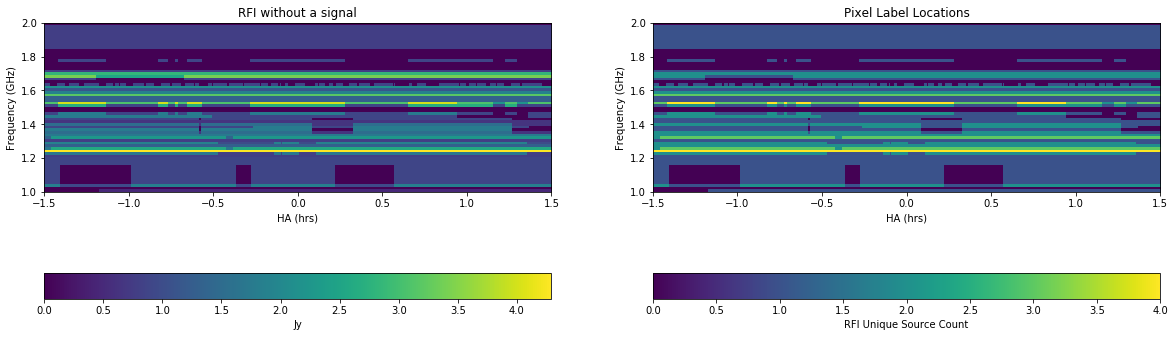

In [18]:
RFI, pixel_labels = RFI_generator2(RFI_pos,unique_sources,RFI_amp)

# Plot an example of what the RFI might look like.
plt.figure(figsize=(20,10))
plt.subplot(121)
plt.title('RFI without a signal')
plt.xlabel('HA (hrs)')
plt.ylabel('Frequency (GHz)')
plt.imshow(RFI,origin='lower',extent=[-1.5,1.5,1,2])
plt.colorbar(orientation='horizontal',label = 'Jy')

plt.subplot(122)
plt.title('Pixel Label Locations')
plt.xlabel('HA (hrs)')
plt.ylabel('Frequency (GHz)')
plt.imshow(np.sum(pixel_labels,axis=2),origin='lower',extent=[-1.5,1.5,1,2])
plt.colorbar(orientation='horizontal',label = 'RFI Unique Source Count')
plt.show()

We add our RFI to our previously generated response and plot this below as an example dirty baseline response function.

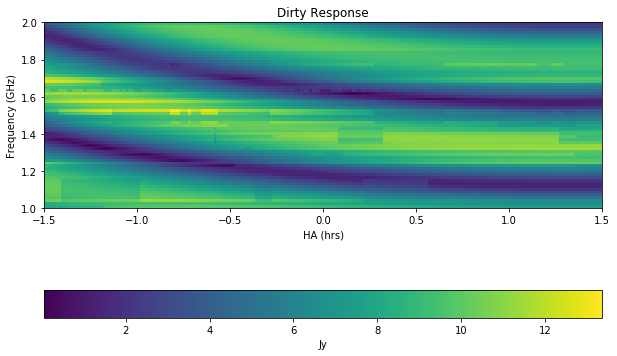

In [19]:
# Add our RFI to our previously generated response
dirty_response = response + RFI
dirty_noisy_response = noisy_response + RFI

# Plot an example of what the RFI might look like with initial response.
plt.figure(figsize=(10,10))
plt.title("Dirty Response")
plt.xlabel('HA (hrs)')
plt.ylabel('Frequency (GHz)')
plt.imshow(abs(dirty_noisy_response),origin='lower',extent=[-1.5,1.5,1,2])
plt.colorbar(orientation='horizontal',label='Jy')
plt.show()

## 4. Creating Data Set

## Contents

1. Array Configuration (and the EVLA's Characteristics)
1. Calculation of Dynamic Spectra
1. RFI Contamination
1. Creating Data Set
1. Machine Learning Training / Evaluation
1. Excising the RFI
1. Conclusion

### Feature extraction

To train our machine learning models we need to pass in features of our data which it can use to make predictions as to what class the data belongs to.

Our initial thought was to use features of a fourrier space as we know that the baselines will have a much more frequency periodic nature in comparison to our RFI. Ie. as our images consist of considerably periodic structures we attempted to extract our feature vectors from the fourrier space of the RFI / dirty responses. 

To demonstrate the practicalities of this, we display the fourrier transforms of the response with RFI as well as the RFI on its own and inverse fourrier transorm these back into the clean response (by subtracting the RFI from the response with RFI) and the RFI on its own.

In [20]:
# Define helper functions to fourrier transform
def ft(image):
    return np.fft.fftshift(np.fft.fft2(image))
def ift(image):
    return np.fft.ifft2(image)

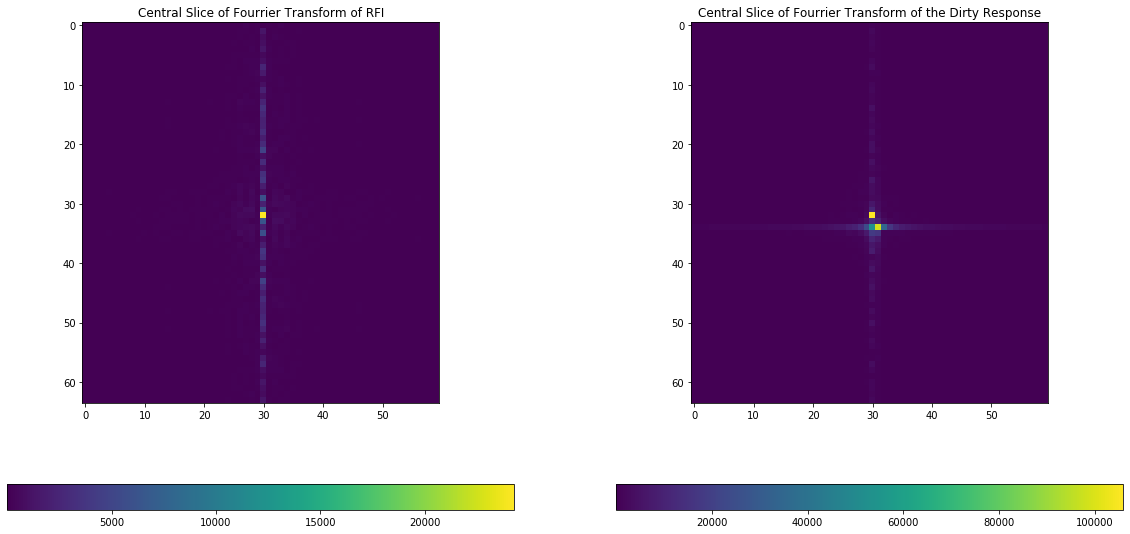

In [21]:
RFI_ft = ft(RFI)
dirty_ft = ft(dirty_noisy_response)

plt.figure(figsize=(20,10))
plt.subplot(121)
plt.title('Central Slice of Fourrier Transform of RFI')
plt.imshow(np.abs(RFI_ft)[:,150:210])
plt.colorbar(orientation='horizontal')

plt.subplot(122)
plt.title('Central Slice of Fourrier Transform of the Dirty Response')
plt.imshow(np.abs(dirty_ft)[:,150:210])
plt.colorbar(orientation='horizontal')
plt.show()

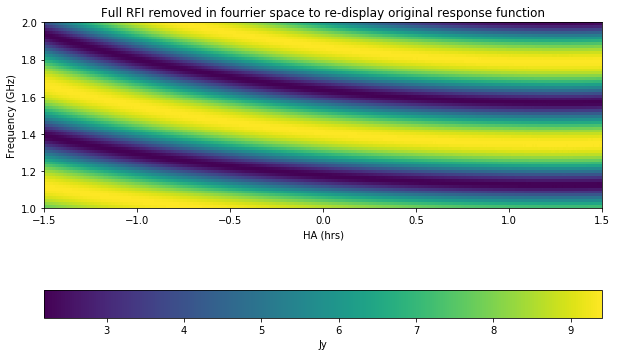

In [22]:
RFI_removed = ift(dirty_ft-RFI_ft)

plt.figure(figsize=(10,10))
plt.xlabel('HA (hrs)')
plt.ylabel('Frequency (GHz)')
plt.title('Full RFI removed in fourrier space to re-display original response function')
plt.imshow(np.abs(RFI_removed),origin='lower',extent=[-1.5,1.5,1,2])
plt.colorbar(orientation='horizontal',label='Jy')
plt.show()

As this method did not improve our models performance by any substantial measure it has been ignored moving forward to minimise the time it takes to generate our dataset.

We excise our RFI by time-slice and thusly extract features from a given time-slice. The features selected were selected for simplicity. There are 37 features:

|Feature No.| Feature Description | Generated on |
|-----------|---------------------|---------|
|0-7|$2^{nd}$ Central Moment (Variance)| Channel Windows |
|8-15|$3^{rd}$ Central Moment| Channel Windows |
|16-23|$4^{th}$ Central Moment| Channel Windows |
|24-31|$5^{th}$ Central Moment| Channel Windows |
|32|$2^{nd}$ Central Moment (Variance)| Entire Time Slice |
|33|$3^{rd}$ Central Moment| Entire Time Slice |
|34|$4^{th}$ Central Moment| Entire Time Slice |
|35|$5^{th}$ Central Moment| Entire Time Slice |
|36|$6^{th}$ Central Moment| Entire Time Slice |

The $n^{th}$ moment is a standard statistical analysis tool defined as: $$m_n = \frac{1}{k}\sum^k_{i=0}(x_i-\bar{x})^n$$ Where $k$ is the number of samples and $\bar{x}$ is the mean.

### Building a Labeled Dataset

To generate a labeled dataset we build a pipeline which generates a full 64x360 spectrograph of RFI with labels for each pixel. Each spectrograph is sliced into 120 windows (or time-slices) which will allow us to make classifications on each of these time-slices individually. To do this we implement three different options for training data with their own counts (see the function `generate_fv()` below):
1. `samples` is the number of RFI spectrographs generated for a single class. Ie. `samples=2` means $2\cdot 120=240$ samples are generated for a single RFI source with no other contaminants. This number of samples will be generated for each of our unique classes.
1. `rand_samples` is the number of RFI spectrographs generated for random combinations of RFI classes. The sources are selected on a uniform distribution and are either 'on' or 'off' for the whole spectrograph. A new random selection will be made for each of the `rand_samples`.
1. `full_samples` is the number of RFI spectrographs generated with all RFI sources in their standard settings (see: 'RFI Contamination' for details).

We choose to weight each of these datatypes in an increasing manor with our best results coming from the selection made below (`samples=0, rand_samples=1024, full_samples=2048`). When training with higher values of `samples` it became apparent that the algorithm was less inclined to predict multiple classes for a single dataset, which is usually an incorrect prediction. Similarly, by having the most samples look like real samples ($2048\cdot 120 = 245760$ samples) the algorithm learns to predict a much better distribution of classes for a single dataset.

As demonstrated in 'Excising the RFI' we classify each time-slice based on which RFI sources are present. By working with the knowledge that we have we do not need to classify the sources that are 'continuous' in nature as their signals are well understood and constant. Therefore, to remove such signals becomes quite a trivial matter in our model. We therefore reduce our `unique_sources` to the number of labels that we are classifying on. The first 17 sources in our model are continuous in nature and therefore can be discounted. We therefore are left with classifying a multilabel problem with 'only' 15 labels. These are listed below.

In [23]:
print(f"We therefore have {unique_sources[17:].shape[0]} classes:\n")
for i in range(unique_sources[17:].shape[0]):
    print(f"Class {i}: {unique_sources[17+i]}")
# Helper variable for future use:
unique_sources_global = unique_sources

We therefore have 15 classes:

Class 0: TARS pulsed radar AZ
Class 1: TARS pulsed radar NM
Class 2: 2nd harmonic VLA radios
Class 3: Aeronautical IFF/air2gnd
Class 4: Aeronautical IFF/gnd2air
Class 5: RATSCAT Low FQ
Class 6: WSMR RAJPO transponder
Class 7: High alt balloon
Class 8: Test telemetry
Class 9: High alt baloon
Class 10: WSMR jamming telemetry
Class 11: Aircraft navigation DME
Class 12: GPS L3 NUDET
Class 13: WSMR telemetry
Class 14: RADIOSONDES- WX baloons


In [41]:
# Function to feature extract from a spectrograph "image" with its pixel labels "labels_temp"
def feature_extraction(image, labels_temp, window_height=8, window_width=3, fourrier=True, width=3):
    # We take slices of each of the images. Currently we take 120 slices (image.shape[1]//window_width=120).
    image=image
    slices = 360//width
    features = []
    for i in range(slices):
        image_sliced = image[:,width*i:width*(i+1)]
        labels_sliced = labels_temp[:,width*i:width*(i+1),:]
        labels_sliced = np.sum(labels_sliced,axis=(0,1))
        labels_sliced = np.where(labels_sliced > 0,1,0)
        # Fourrier transform image if desired:
        if fourrier:
            image_sliced = ft(image_sliced)
        # Extract slices / windows of image:
        windows = np.zeros((1,window_height,window_width))
        for j in range(0,width//window_width):
            for i in range(0,64//window_height):
                windows = np.append(windows,[image_sliced[i*window_height:(i+1)*window_height,j*window_width:(j+1)*window_width]],axis=0)
        total = np.sum(windows[1:])
        
        # Extract features:
        mom1 = windows[1:].mean(axis=(1,2))
        
        mom2all = windows[1:].var(axis=(1,2))
        mom3all = moment(np.reshape(windows[1:],(-1,window_height*window_width)),moment=3,axis=1)
        mom4all = moment(np.reshape(windows[1:],(-1,window_height*window_width)),moment=4,axis=1)
        mom5all = moment(np.reshape(windows[1:],(-1,window_height*window_width)),moment=5,axis=1)
        
        mom2 = moment(mom1,moment=2)
        mom3 = moment(mom1,moment=3)
        mom4 = moment(mom1,moment=4)
        mom5 = moment(mom1,moment=5)
        mom6 = moment(mom1,moment=6)
        
        # Concatenate all features back into one array per dataset (window/slice)
        fv_temp = np.asarray([mom2all,mom3all,mom4all,mom5all])
        fv = np.array([mom2,mom3,mom4,mom5,mom6])
        fv = np.append(fv_temp,fv)
        features.append(fv)

        # Save labels for each window/slice
        try:
            labels_local = np.append(labels_local,labels_sliced)
        except:
            labels_local = labels_sliced
    features = np.asarray(features)

    # Reshape Outputs
    labels_local = np.reshape(labels_local,(-1,32))
    features = np.reshape(features,(-1,37))

    # Output features and labels in shape (120,37) and (120,32) respectively
    return features , labels_local

In [25]:
# Dataset generating function
def generate_fv(unique_sources,samples=4,rand_samples=1024,full_samples=1024, fourrier=True , save=True , idealized=True, w_height=8,w_width=3):
    try:
        # Try loading in data if the dataset has alread been generated.
        fv_out = np.load(f"./data/V4_simulated_RFI_fv{samples}-{rand_samples}-{full_samples}-{fourrier}.npy")
        labels = np.load(f"./data/V4_simulated_RFI_labels{samples}-{rand_samples}-{full_samples}-{fourrier}.npy")
        print("Data successfully loaded!")
    except:
        print("Data will be generated.")
        # Initialise helper objects.
        classes = unique_sources.size
        feature_vectors = np.zeros((1,37))
        width = 3
        labels = np.zeros(((classes*samples+rand_samples+full_samples)*360//width,classes))
        window_height, window_width = w_height, w_width    

        # For each unique class generate a dataset of length 'samples'
        for q in range(classes):
            location = np.where(RFI_labels == unique_sources[q])
            # Keeping track of the labels as hot-vectors.
            hot_vec = np.zeros((classes))
            hot_vec = np.append(np.ones(17),hot_vec)
            hot_vec[q+17]=1
            counter=0
            # Generate N 'samples' for each class:
            for p in range(samples):
                counter+=1
                # Generating the RFI of the specific label and fourrier transforming it.
                RFI_temp , labels_2 = RFI_generator2(RFI_pos[location],RFI_labels[location],RFI_amp[location],idealized=idealized)
                features , labels_2 = feature_extraction(RFI_temp,labels_2,window_height,window_width,fourrier,width=width)
                feature_vectors = np.append(feature_vectors,features,axis=0)
                labels_2 = np.reshape(labels_2,(-1,32))
                labels[(q*samples+p)*360//width:(q*samples+p+1)*360//width] = labels_2[:,17:]
            print(f'Generated all {counter*360//width} samples of class {q+1} of {classes} ({counter} by {360//width} slices per class).')

            
        # Same as above but with randomly initiated combinations of RFI ('rand_samples' dependant).
        hot_rand = np.random.randint(0,2,(rand_samples,classes))
        hot_rand = np.append(np.ones((rand_samples,32-classes)),hot_rand,axis=1)
        distribution = np.zeros((32))
        print('Moving on to random sample generation ...')
        for q in range(rand_samples):
            # Print something to keep up to visualise how much has been generated thus far.
            if q in np.arange(0,5000,250):
                print(f"We have completed {feature_vectors[1:].shape[0]}/{labels.shape[0]} and are finished our {q}'th random generation ({int(100*feature_vectors[1:].shape[0]/labels.shape[0])}%)")

            p = np.asarray(np.where(hot_rand[q]==1)).squeeze()
            # Generating the RFI of the specific label(s)
            RFI_temp_ = np.zeros((64,360))
            labels_2_temp = np.zeros((64,360,32))
            for i in range(p.size):
                location = np.where(RFI_labels == unique_sources_global[p[i]])
                # Please note: idealized in the RFI_generator2() function sets if the samples are all seen as continuous or not.
                RFI_temp , labels_2_ = RFI_generator2(RFI_pos[location],RFI_labels[location],RFI_amp[location],idealized=idealized)
                RFI_temp_ += RFI_temp
                labels_2_temp += labels_2_
            features , labels_2_temp = feature_extraction(RFI_temp,labels_2_temp,window_height,window_width,fourrier,width=width)
            
            feature_vectors = np.append(feature_vectors,features,axis=0)
            labels[(classes*samples+q)*360//width:(classes*samples+q+1)*360//width] = np.reshape(labels_2_temp,(-1,32))[:,17:]
            
        # Same as above but with RFI generated according to their class type (intermittent vs continuous etc.) ie. idealized=False.
        hot_full = np.ones((full_samples,classes))
        print('Moving on to full / natural sample generation ...')
        for q in range(full_samples):
            # Print something to keep up to date with how much has been generated.
            if q in np.arange(0,5000,250):
                print(f"We have completed {feature_vectors[1:].shape[0]}/{labels.shape[0]} and are finished our {q}'th full generation ({int(100*feature_vectors[1:].shape[0]/labels.shape[0])}%)")
            RFI_temp,labels_2_temp = RFI_generator2(RFI_pos,RFI_labels,RFI_amp,idealized=False)
            features , labels_2_temp = feature_extraction(RFI_temp,labels_2_temp,window_height,window_width,fourrier,width=width)
            feature_vectors = np.append(feature_vectors,features,axis=0)
            labels[(classes*samples+rand_samples+q)*360//width:(classes*samples+rand_samples+q+1)*360//width] = np.reshape(labels_2_temp,(-1,32))[:,17:]
        fv_out = feature_vectors[1:]
        # Save data if not testing this block specifically.
        if save:
            np.save(f"./data/V4_simulated_RFI_fv{samples}-{rand_samples}-{full_samples}-{fourrier}",fv_out)
            np.save(f"./data/V4_simulated_RFI_labels{samples}-{rand_samples}-{full_samples}-{fourrier}",labels)
            print("Data will be saved for next time.")
        print(f"We have completed {feature_vectors[1:].shape[0]}/{labels.shape[0]} and are finished data generation ({int(100*feature_vectors[1:].shape[0]/labels.shape[0])}%)")
    return fv_out, labels

We are now ready to generate our dataset.

In [26]:
# Call function to generate labels and feature vectors (will load data if the same sample has already been generated)
feature_vectors , labels = generate_fv(unique_sources[17:],
                                       samples=0,
                                       rand_samples=1024,
                                       full_samples=2048,
                                       fourrier=False,
                                       save=True)

Data successfully loaded!


## 5. Machine Learning Training / Evaluation

## Contents

1. Array Configuration (and the EVLA's Characteristics)
1. Calculation of Dynamic Spectra
1. RFI Contamination
1. Creating Data Set
1. Machine Learning Training / Evaluation
1. Excising the RFI
1. Conclusion

Classically classification problems are a singular binary classification. As an example consider a classifier of whether an image is of a cat or a dog, a car or not a car etc. Due to how we aim to excise the RFI we have a **multi-label** problem. Meaning we not only have multiple classes (e.g. cat or dog or elephant or horse) but also have multiple classes being represented in a singular sample (e.g a selection of 10p coin, 5p coin, £1 coin etc. in a singular image). In our case it is possible that anywhere between 0 and 15 of our classes appear in a single sample.

First let us look at how many samples we have generated and what a label might acctually look like:

In [27]:
print(f'We have {feature_vectors.shape[0]} total samples with {feature_vectors.shape[1]} features and {labels.shape[1]} classes as previously discussed.')
print(f'Example of a label: {labels[np.argmax(labels)]}')

We have 368640 total samples with 37 features and 15 classes as previously discussed.
Example of a label: [1. 1. 1. 1. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 1.]


We shuffle our data and split it into training and testing sets.

In [28]:
# Shuffle training data and take absolute values (complex not supported by standard ML packages)
X = np.abs(feature_vectors)
y_labels = labels

X_train, X_test, y_train, y_test = train_test_split(X, y_labels, test_size=0.3, random_state=12)

The algorithm we choose is a random forrest. This method generates a number of decision trees using a subset of our features and then samples them randomly to generate multiple decision trees which collectively make a prediciton based on the input. For more on the algorithm and this implementation please see: https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html#sklearn.ensemble.RandomForestClassifier.

We also have run the entire notebook using a k-nearest neighbours algorithm and have seen minimal improvements in previous iterations and therefore arbitrarily select the Random Forrest as our method to evaluate (see: https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html).

We elected to use these algorithms due to their simplicity, popularity (meaning they can be researched and understood relatively easily), as well as their ability to extend to the multilabel problem we are trying to solve. We now call our random forrest and fit it with our training data.

In [29]:
# Initialise our random forrest and train it on the training data.
clfRF = RandomForestClassifier(n_estimators=100, max_depth = 20,random_state=0,criterion='entropy')
clfRF.fit(X_train,y_train)
clf = clfRF

In [30]:
#y_pred = clfKNN.predict(X_test)
y_pred = clfRF.predict(X_test)

One way we can evaluate the effectiveness of our chosen features is by plotting their relative importances. Because we have $37$ features, we would expect a balanced system to display features with values of $1/37 \approx 2.7\%$ each.

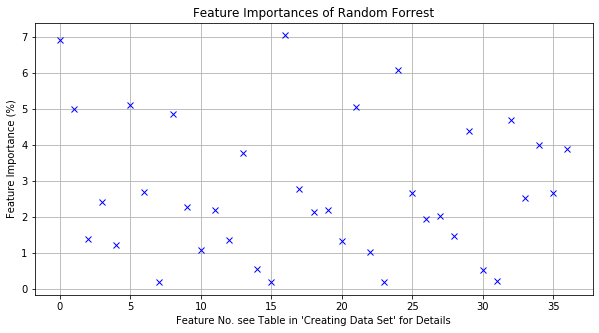

In [31]:
plt.figure(figsize=(10,5))
plt.title('Feature Importances of Random Forrest')
plt.xlabel("Feature No. see Table in 'Creating Data Set' for Details")
plt.ylabel("Feature Importance (%)")
plt.grid()
plt.plot(clfRF.feature_importances_*100,'bx')
plt.show()

We see that the features are not all equally weighted but they do not follow a specific order either. No individual feature is significantly out weighing the other weights indicating that the algorithm is training and not just 'guessing' at the prediction.

A common evaluation method is to look at the confusion matrix of a classification, which simply plots a heatmap of the true class against the predicted class. For multilabel classification this is not particularly easy to visualise as each data set can have multiple classes associated with it. Therefore we output the respective "one-vs-rest" (see: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.multilabel_confusion_matrix.html) accuracies of each individual class (ie.: (True Positives + True Negatives)/Total).

In [32]:
confusion_binary = multilabel_confusion_matrix(y_pred,y_test)
print('The accuracies of individual classes: \n')
for i in range(confusion_binary.shape[0]):
    confusion = confusion_binary[i]
    accuracy = (confusion[0,0]+confusion[1,1])/np.sum(confusion)
    print(f"{accuracy*100:.2f}% for Class No. {i}: {unique_sources[17+i]}")

The accuracies of individual classes: 

84.66% for Class No. 0: TARS pulsed radar AZ
82.22% for Class No. 1: TARS pulsed radar NM
84.30% for Class No. 2: 2nd harmonic VLA radios
84.25% for Class No. 3: Aeronautical IFF/air2gnd
84.15% for Class No. 4: Aeronautical IFF/gnd2air
83.91% for Class No. 5: RATSCAT Low FQ
84.86% for Class No. 6: WSMR RAJPO transponder
69.46% for Class No. 7: High alt balloon
83.73% for Class No. 8: Test telemetry
84.42% for Class No. 9: High alt baloon
82.41% for Class No. 10: WSMR jamming telemetry
86.65% for Class No. 11: Aircraft navigation DME
73.26% for Class No. 12: GPS L3 NUDET
79.61% for Class No. 13: WSMR telemetry
99.93% for Class No. 14: RADIOSONDES- WX baloons


We expect a worse case accuracy of $\approx 50\%$ for each class as this would mean that for each class the model is entirely unsure.

We can also evaluate how often a prediction is made for which class by our algorithm. In the below graph we plot the total counts of the appearances of a given label in our test samples, and the number of predicitons made of that class. We can see that the method learns the approximate distribution that we have initiated but over estimates the rates individual classes (green extent) and underestimates the rates of others (blue extent).

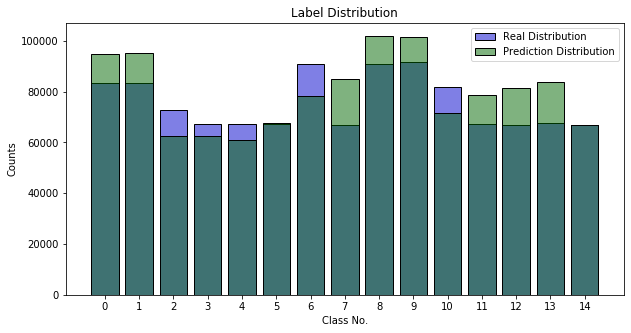

In [33]:
predicted_distr = np.sum(y_pred,axis=0)
true_distr = np.sum(y_test,axis=0)
plt.figure(figsize=(10,5))
plt.title('Label Distribution')
plt.xlabel('Class No.')
plt.ylabel('Counts')
plt.xticks(range(15))
plt.bar(np.arange(15),true_distr,color=(0.,0.,0.8,0.5),edgecolor='black')
plt.bar(np.arange(15),predicted_distr,color=(0.,0.4,0.,0.5),edgecolor='black')
plt.legend(['Real Distribution','Prediction Distribution'])
plt.show()

For a more formal evaluation of our model we use three metrics that are widely used for multilabel classificaiton:
1. The Coverage Error is a metric which estimates the average number of classifications we must assign a single dataset to classify it fully. Our value here should be between $\frac{No.OfClasses*MeanClassOccurance}{No.OfSamples}\approx 10.236$ (best) and 15 (worst).
1. Label ranking average precision (LRAP) is the multilabel equivalent of the mean reciprocal rank. The more certain the model is of the correct choice the higher this value. $LRAP \in [0,1]$ with 1 meaning it is certain in every position of every classification. (Whilst testing our model and its parameters this value ranged between $0.3$ and $0.65$ with our current value being the highest by a significant margin.)
1. The label ranking loss indicates the average ranking loss over all labels. Ranking loss is lower for labels which are predicted 'more correctly' (ie. smaller number of transpositions until the correct label is reached).

For more details on these metrics and how they are implemented, please see: https://scikit-learn.org/stable/modules/model_evaluation.html#multilabel-ranking-metrics (visited 02.12.2019)

In [34]:
cov_error = coverage_error(y_test,y_pred)
avg_precision = label_ranking_average_precision_score(y_test,y_pred)
rank_loss = label_ranking_loss(y_test,y_pred)

print(
    f"""Evaluation Metrics:
1. Coverage Error: \t{cov_error:.2f}
2. LRAP: \t\t{avg_precision:.4f}
3. Label ranking loss: \t{rank_loss:.4f}""")

Evaluation Metrics:
1. Coverage Error: 	13.34
2. LRAP: 		0.8205
3. Label ranking loss: 	0.3518


## 6. Excising the RFI

## Contents

1. Array Configuration (and the EVLA's Characteristics)
1. Calculation of Dynamic Spectra
1. RFI Contamination
1. Creating Data Set
1. Machine Learning Training / Evaluation
1. Excising the RFI
1. Conclusion

We can now classify our RFI on each of our 120 time-slices. To excise it from the original image it we will generate time-slice samples of each RFI source (individually) and subtract them from the input based on the prediction. First let us view what our predictions even look like. For each of the 120 time-slices we have 15 classes either predicted (1) or predicted to not be present (0). The below image displays how chaotic this might look. As each class can pertain to up to 6 signals at varying frequencies / intensities the below visualisation is still a move understandable visualisation of the classifications.

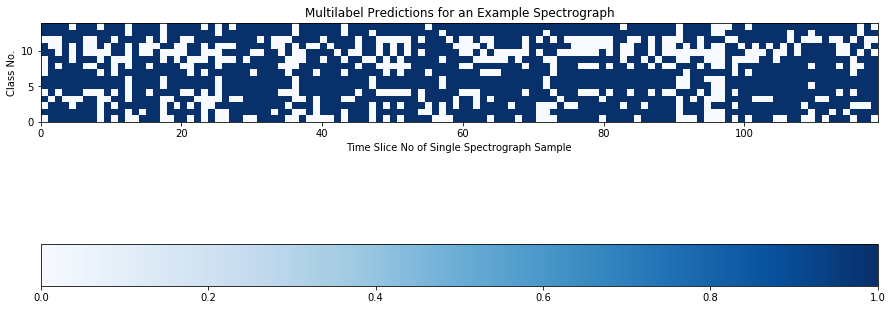

In [35]:
plt.figure(figsize=(15,15))
plt.title('Multilabel Predictions for an Example Spectrograph')
plt.ylabel('Class No.')
plt.xlabel('Time Slice No of Single Spectrograph Sample')
plt.imshow(y_pred[:120].T,extent=[0,119,0,14],cmap='Blues')
plt.colorbar(orientation='horizontal')
plt.show()

We decided to attempt to remove the RFI whilst preserving as much of the response to the source as possible. In our model we therefore expect the EVLA to have access to the same information as we do (if not more accurate) and expect that if we can classify when a given source of RFI is affecting our spectrograph we should be able to restore the response by taking the difference between our dirty response and the clean signal of the respective RFI source. In doing so, we negate the need to classify 'continuous' sources of RFI as they can be assumed to always be affecting the response and can be removed in the same way wihtout the need for classificaiton (in our model at least).

We generate `RFI_samples` which contains the ideal time-slice signals of all RFI sources.

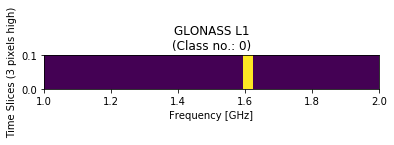

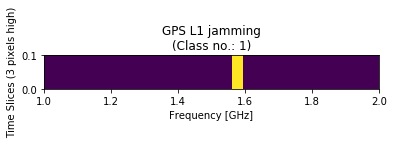

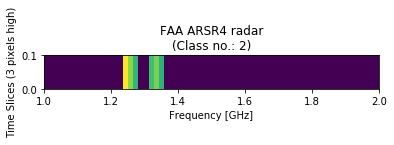

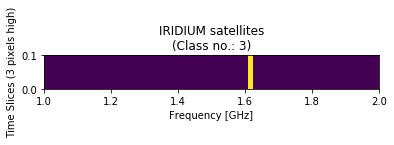

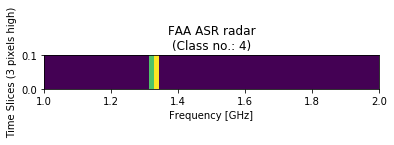

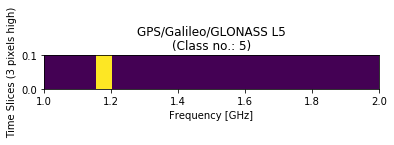

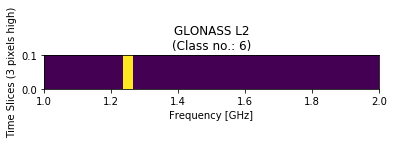

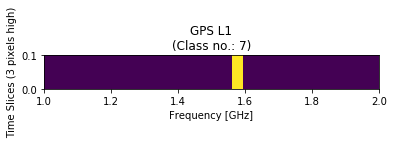

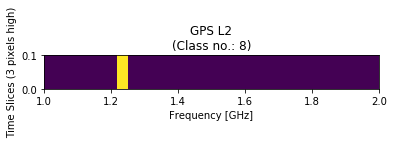

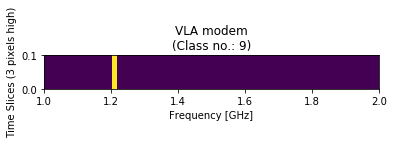

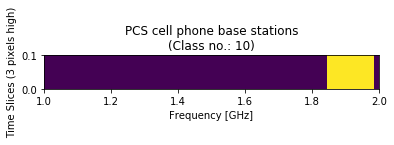

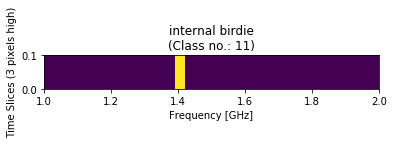

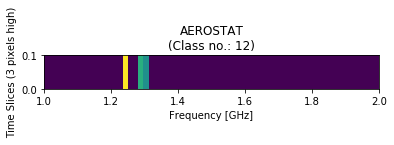

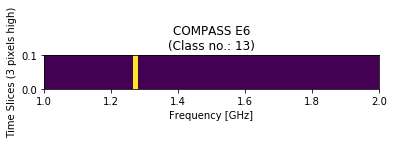

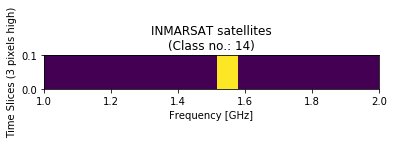

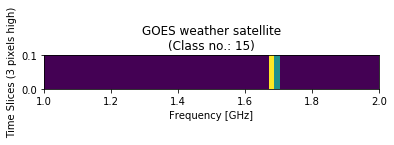

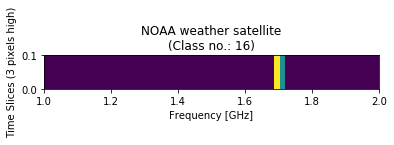

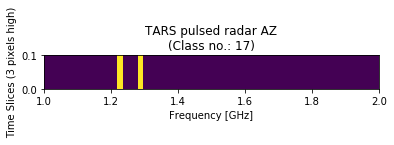

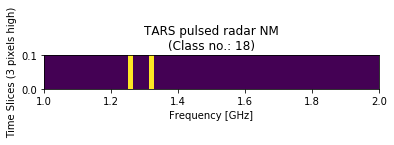

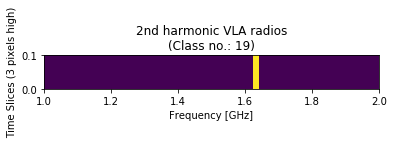

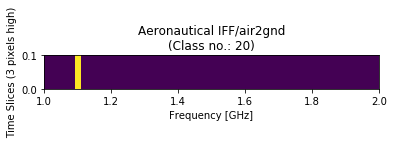

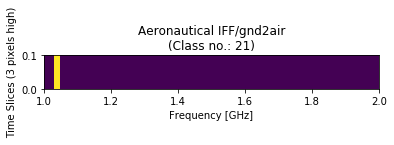

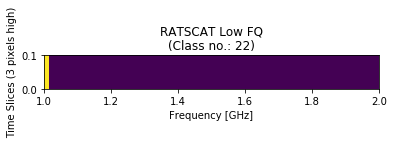

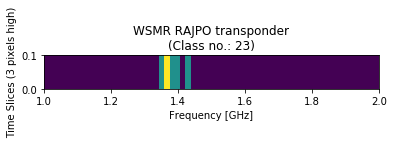

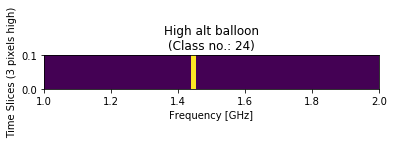

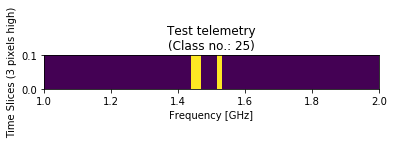

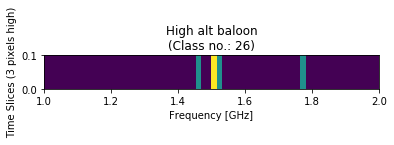

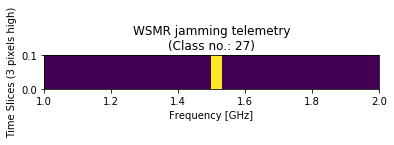

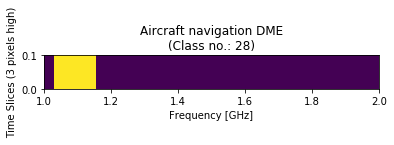

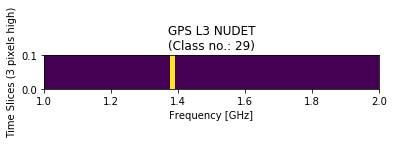

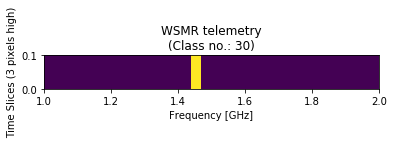

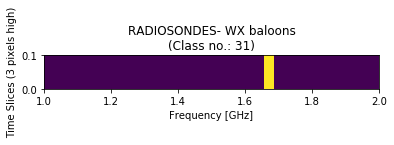

We have generated an array of dimensions:
32x64x3 ie. Classes by the dimensions of a time slice.


In [36]:
RFI_continuous = []
for i in range(len(RFI_class)):
    RFI_continuous.append('continuous')
RFI_continuous = np.asarray(RFI_continuous,dtype=np.str)

# Initialise helper objects.
classes = unique_sources_global.size
width = 3
#labels = np.zeros((360//width,classes))
RFI_samples = np.zeros((32, 64, width))

for q in range(classes):
    location = np.where(RFI_labels == unique_sources[q])
    # Keeping track of the labels as hot-vectors.
    hot_vec = np.zeros((classes))
    hot_vec[q]=1
    # Generating the RFI of the specific label.
    RFI_temp , labels_2 = RFI_generator2(RFI_pos[location],unique_sources_global[q],RFI_amp[location],idealized=True)
    RFI_samples[q] = RFI_temp[:,0:width]
    # Plotting the RFI of the specific class no.
    plt.title(f"{unique_sources_global[q]}\n(Class no.: {q})")
    plt.ylabel('Time Slices (3 pixels high)')
    plt.xlabel('Frequency [GHz]')
    plt.imshow(RFI_samples[q].T,origin='lower',extent=[1,2,0,0.1])
    plt.show()
print(f'We have generated an array of dimensions:\n{RFI_samples.shape[0]}x{RFI_samples.shape[1]}x{RFI_samples.shape[2]} ie. Classes by the dimensions of a time slice.')

We define a function `remove_RFI(*args)` to clean our dirty RFI of our determined RFI sources.

In [37]:
def remove_RFI(dirty_response, RFI_labels, RFI_samples):
    cleaned_response = dirty_response
    # Iterate over time slices to remove expected and predicted RFI
    window_width = dirty_response.shape[1]//RFI_labels.shape[0]
    for i in range(RFI_labels.shape[0]):
        local_RFI = np.append(np.ones(17),RFI_labels[i])
        for j in range(local_RFI.shape[0]):
            cleaned_response[:,window_width*i:window_width*(i+1)] = cleaned_response[:,window_width*i:window_width*(i+1)] - RFI_samples[j]*local_RFI[j]
    return cleaned_response

We will now generate a full noisy baseline response including RFI which will be used throughout the remainder of this example RFI excision.

In [38]:
RFI, pixel_labels = RFI_generator2(RFI_pos,unique_sources,RFI_amp,idealized=False)

RFI = np.abs(RFI)
Response = np.abs(clean_response(27, 1)) #Reminder: Values must be  element of: [1,27]
noise = noise_func()*10.0E26 #[Jy]
noise = np.zeros((64,360))
dirty_noisy_response = Response+noise+RFI

(64, 360)


We plot the RFI, true label locations, response and dirty response to illustrate the effects of our RFI sample.

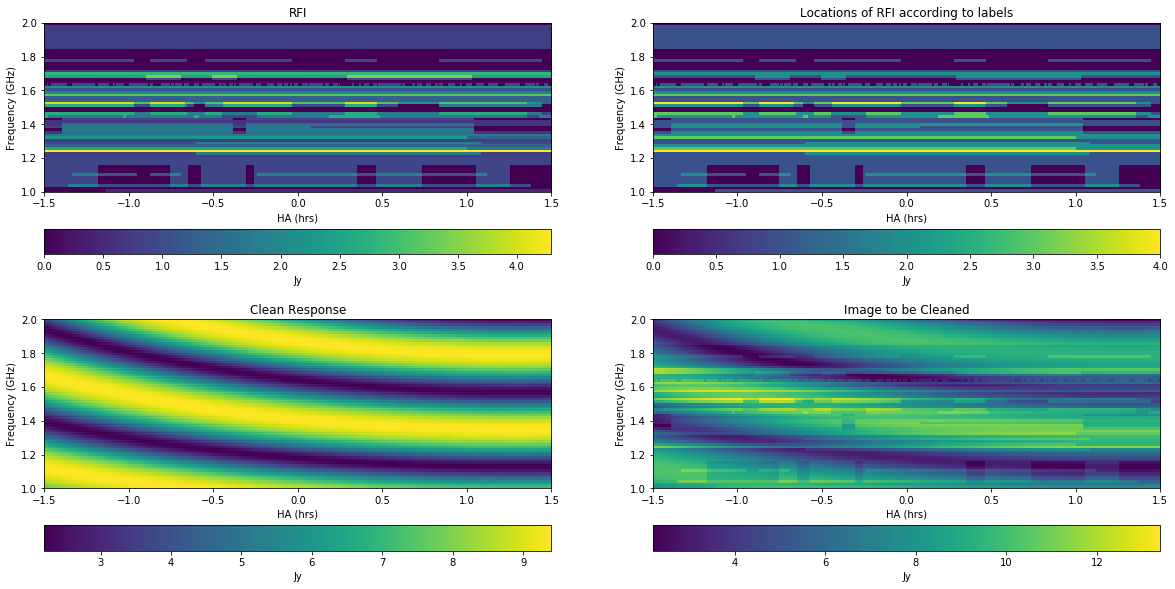

In [39]:
plt.figure(figsize=(20,10))

plt.subplot(221)
plt.title('RFI')
plt.xlabel('HA (hrs)')
plt.ylabel('Frequency (GHz)')
plt.imshow(RFI,origin='lower',extent=[-1.5,1.5,1,2])
plt.colorbar(orientation='horizontal',label='Jy')


RFI_binary = np.sum(pixel_labels,axis=2)
plt.subplot(222)
plt.title('Locations of RFI according to labels')
plt.xlabel('HA (hrs)')
plt.ylabel('Frequency (GHz)')
plt.imshow(RFI_binary,origin='lower',extent=[-1.5,1.5,1,2])
plt.colorbar(orientation='horizontal',label='Jy')

plt.subplot(223)
plt.title('Clean Response')
plt.xlabel('HA (hrs)')
plt.ylabel('Frequency (GHz)')
plt.imshow(np.abs(Response),origin='lower',extent=[-1.5,1.5,1,2])
plt.colorbar(orientation='horizontal',label='Jy')

plt.subplot(224)
plt.title('Image to be Cleaned')
plt.xlabel('HA (hrs)')
plt.ylabel('Frequency (GHz)')
plt.imshow(dirty_noisy_response,origin='lower',extent=[-1.5,1.5,1,2])
plt.colorbar(orientation='horizontal',label='Jy')
plt.show()

We extract our features from this generated sample and evaluate our models predictions for the multilabel classificaiton throughout the time windows of the spectrograph.

In [42]:
features_final, labels_final = feature_extraction(dirty_noisy_response,pixel_labels,fourrier=False)
features_RFI_only , temp = feature_extraction(RFI,pixel_labels,fourrier=False)
prediction = clf.predict(np.abs(features_final))

In [43]:
labels_RFI_only = clf.predict(np.abs(features_RFI_only))
labels_pred = clf.predict(np.abs(features_final))

As we know from the evaluation of our model, we do not have a perfect prediction rate and therefore will not get a perfectly clean source.

We demonstrate the ideal version of our cleaning method by removing based off of our generated labels, ie. the true values. In fact, we still expect some errors especially at the start/end of a RFI signal as we do not account for partial RFI removal. We plot an array of images which demonstrate how our model performs on a given baseline and that it classifies subjectively similar on both a dirty response as well as on RFI (without any response).

In [44]:
# Extract labels for each window from pixel_labels
ideal_labels = np.zeros((120,32))
for i in range(360//width):
    ideal_labels[i] = pixel_labels[:,i*width:(i+1)*width].sum(axis=(0,1))
ideal_labels = np.where(ideal_labels>0,1,0)

# Clean image based on various labels for comparison:
cleaned_response_ideal = remove_RFI(np.abs(dirty_noisy_response),ideal_labels[:,17:],RFI_samples)
cleaned_response_model = remove_RFI(np.abs(dirty_noisy_response),labels_pred,RFI_samples)
cleaned_RFI_model = remove_RFI(np.abs(dirty_noisy_response),labels_RFI_only,RFI_samples)
cleaned_response_worst = remove_RFI(np.abs(dirty_noisy_response),np.zeros((120,15)),RFI_samples)

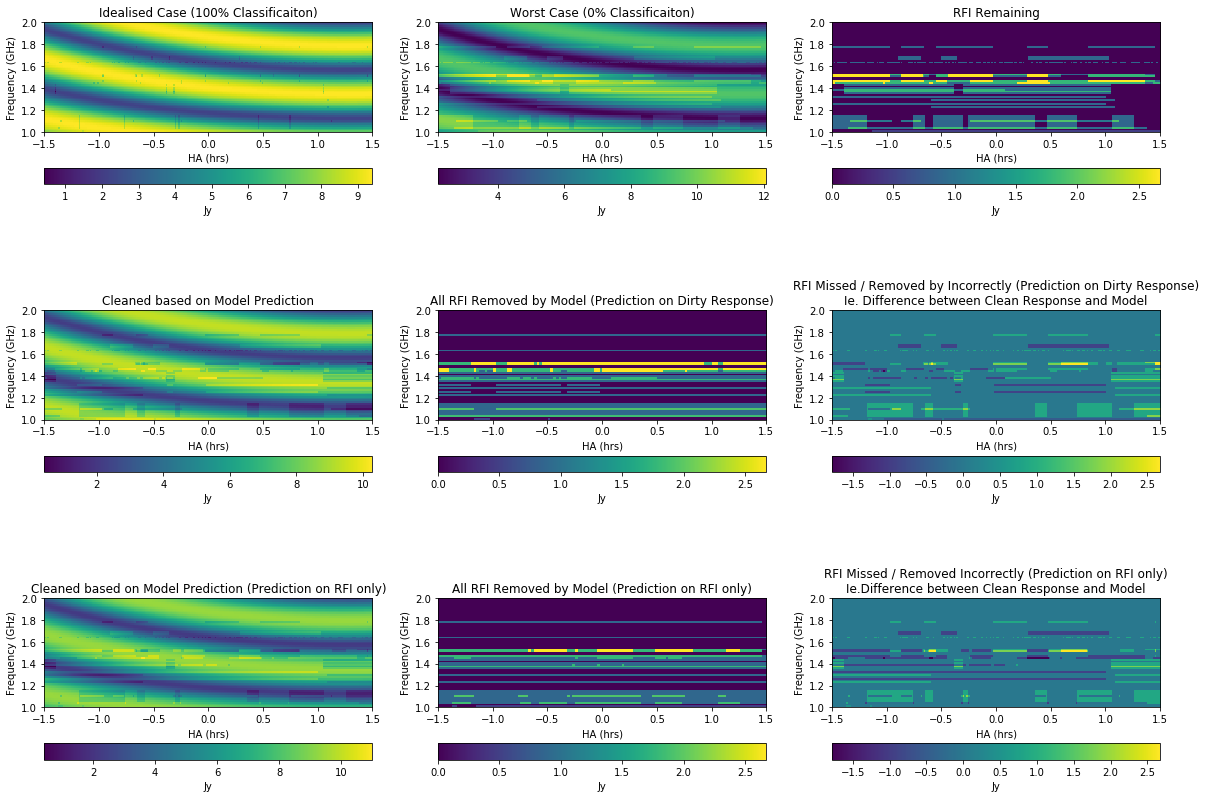

In [45]:
plt.figure(figsize=(20,15))

image1 = cleaned_response_ideal
plt.subplot(331)
plt.title('Idealised Case (100% Classificaiton)')
plt.xlabel('HA (hrs)')
plt.ylabel('Frequency (GHz)')
plt.imshow(image1,origin='lower',extent=[-1.5,1.5,1,2])
plt.colorbar(orientation='horizontal',label='Jy')
#plt.clim(0,12)

image2 = cleaned_response_worst
plt.subplot(332)
plt.title('Worst Case (0% Classificaiton)')
plt.xlabel('HA (hrs)')
plt.ylabel('Frequency (GHz)')
plt.imshow(image2,origin='lower',extent=[-1.5,1.5,1,2])
plt.colorbar(orientation='horizontal',label='Jy')
#plt.clim(0,12)

#image3 = RFI
image3 = image2-np.abs(Response)
plt.subplot(333)
plt.title('RFI Remaining')
plt.xlabel('HA (hrs)')
plt.ylabel('Frequency (GHz)')
plt.imshow(image3,origin='lower',extent=[-1.5,1.5,1,2])
plt.colorbar(orientation='horizontal',label='Jy')
#plt.clim(0,12)

image4 = cleaned_response_model
plt.subplot(334)
plt.title('Cleaned based on Model Prediction')
plt.xlabel('HA (hrs)')
plt.ylabel('Frequency (GHz)')
plt.imshow(image4,origin='lower',extent=[-1.5,1.5,1,2])
plt.colorbar(orientation='horizontal',label='Jy')
#plt.clim(0,12)

image5 = cleaned_response_worst-cleaned_response_model
plt.subplot(335)
plt.title('All RFI Removed by Model (Prediction on Dirty Response)')
plt.xlabel('HA (hrs)')
plt.ylabel('Frequency (GHz)')
plt.imshow(image5,origin='lower',extent=[-1.5,1.5,1,2])
plt.colorbar(orientation='horizontal',label='Jy')
#plt.clim(0,12)

image6 = (np.abs(Response)-cleaned_response_model)
plt.subplot(336)
plt.title('RFI Missed / Removed by Incorrectly (Prediction on Dirty Response)\nIe. Difference between Clean Response and Model')
plt.xlabel('HA (hrs)')
plt.ylabel('Frequency (GHz)')
plt.imshow(image6,origin='lower',extent=[-1.5,1.5,1,2])
plt.colorbar(orientation='horizontal',label='Jy')
#plt.clim(0,12)

image7 = cleaned_RFI_model
plt.subplot(337)
plt.title('Cleaned based on Model Prediction (Prediction on RFI only)')
plt.xlabel('HA (hrs)')
plt.ylabel('Frequency (GHz)')
plt.imshow(image7,origin='lower',extent=[-1.5,1.5,1,2])
plt.colorbar(orientation='horizontal',label='Jy')
#plt.clim(0,12)

image8 = cleaned_response_worst-cleaned_RFI_model
plt.subplot(338)
plt.title('All RFI Removed by Model (Prediction on RFI only)')
plt.xlabel('HA (hrs)')
plt.ylabel('Frequency (GHz)')
plt.imshow(image8,origin='lower',extent=[-1.5,1.5,1,2])
plt.colorbar(orientation='horizontal',label='Jy')
#plt.clim(0,12)


image9 = np.abs(Response)-cleaned_RFI_model
plt.subplot(339)
plt.title('RFI Missed / Removed Incorrectly (Prediction on RFI only)\nIe.Difference between Clean Response and Model')
plt.xlabel('HA (hrs)')
plt.ylabel('Frequency (GHz)')
plt.imshow(image9,origin='lower',extent=[-1.5,1.5,1,2])
plt.colorbar(orientation='horizontal',label='Jy')
#plt.clim(0,12)
plt.show()

## 7. Conclusion

## Contents

1. Array Configuration (and the EVLA's Characteristics)
1. Calculation of Dynamic Spectra
1. RFI Contamination
1. Creating Data Set
1. Machine Learning Training / Evaluation
1. Excising the RFI
1. Conclusion

The model predicted nominally well, but could be improved quite readily in a number of ways, by hyperparameter optimization and / or the application of different algorithms. To move forward the next steps would include increasing the detail in our training data meaning the resolution of our spectrographs. This would allow our algorithm to 'see' different signal types which would aid classification.
By adding a second classifier we could consolodate our RFI predictions (help in the final cleaning stage) and mask out any signals that we may have missed or come from RFI sources other than the ones we initially trained on.

This should help generate very clean images which preserve as much of the signal as possible. As masking all of the RFI affected regions of the spectrograph would have caused serious loss in signal there seems to validity to this method as a whole although given more time a hybrid method as described above would yield much cleaner results with misclassified regions being reduced and all remaining RFI being masked out as required.